In [1]:
import matplotlib.pyplot as plt
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
from dipy.segment.mask import median_otsu

In [3]:
def generateWhiteMatterMask():
    threshold = 0.25
    for i in range(21,24):
        print("CASE "+str(i))
        TRAIN_DATA = '../test_data/case_'+str(i)
        diffussionData, affine = load_nifti(TRAIN_DATA+'/Diffusion.nii.gz')
        labels = load_nifti_data(TRAIN_DATA+'/brain_mask.nii.gz')
        bvals, bvecs = read_bvals_bvecs(TRAIN_DATA+'/Diffusion.bvals', TRAIN_DATA+'/Diffusion.bvecs')
        gtab = gradient_table(bvals, bvecs)
        white_matter = (labels == 1) | (labels == 2)
        maskData,mask = median_otsu(diffussionData, vol_idx=range(0,9),numpass=1,dilate=5)
        dti_model = TensorModel(gtab)
        dti_peaks = peaks_from_model(dti_model, maskData, default_sphere,
                             relative_peak_threshold=.75,
                             min_separation_angle=45,
                             mask=white_matter)
        
        sli = dti_peaks.gfa.shape[2] // 2
        plt.figure('GFA')
        plt.subplot(1, 2, 1).set_axis_off()
        plt.imshow(dti_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')
        plt.subplot(1, 2, 2).set_axis_off()
        plt.imshow((dti_peaks.gfa[:, :, sli] > threshold).T, cmap='gray', origin='lower')
        plt.savefig('gfa_tracking_mask_'+str(i)+'.png')
        # threeshold model and generate white matter mask
        whiteMatterMask = np.where(dti_peaks.gfa >threshold,255,0)
        save_nifti(TRAIN_DATA+'/white_matter.nii.gz',whiteMatterMask,affine)

CASE 21
CASE 22


<ipython-input-3-682511dcf1a6>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1).set_axis_off()
<ipython-input-3-682511dcf1a6>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2).set_axis_off()


CASE 23


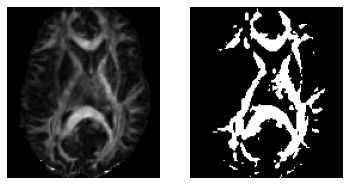

In [4]:
generateWhiteMatterMask()

In [208]:
TRAIN_DATA = '../train_data/case_1'

In [209]:
# read diffusion data
#diffussionData, affine, img = load_nifti(TRAIN_DATA+'/Diffusion.nii.gz',return_img=True)
diffussionData, affine = load_nifti(TRAIN_DATA+'/Diffusion.nii.gz')

In [210]:
# read labels data
labels = load_nifti_data(TRAIN_DATA+'/brain_mask.nii.gz')

In [211]:
# read tensor data
bvals, bvecs = read_bvals_bvecs(TRAIN_DATA+'/Diffusion.bvals', TRAIN_DATA+'/Diffusion.bvecs')

In [212]:
# generate gradient table from bvals and bvecs
gtab = gradient_table(bvals, bvecs)

In [213]:
white_matter = (labels == 1) | (labels == 2)

In [214]:
maskData,mask = median_otsu(diffussionData, vol_idx=range(0,9),numpass=1,dilate=5)

## DTI Model according to GradientTable object

In [2]:
import numpy as np
from dipy.reconst.dti import TensorModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

In [215]:
dti_model = TensorModel(gtab)

In [216]:
dti_peaks = peaks_from_model(dti_model, maskData, default_sphere,
                             relative_peak_threshold=.75,
                             min_separation_angle=45,
                             mask=white_matter)

In [274]:
# define threshold value
threshold = 0.25

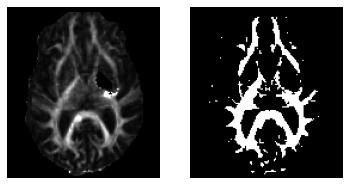

In [275]:
sli = dti_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(dti_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((dti_peaks.gfa[:, :, sli] > threshold).T, cmap='gray', origin='lower')
plt.savefig('gfa_tracking_mask_1.png')

In [276]:
# threeshold model and generate white matter mask
whiteMatterMask = np.where(dti_peaks.gfa >threshold,255,0)

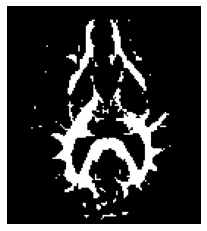

In [284]:
plt.figure('GFA')
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(whiteMatterMask[:, :, sli].T, cmap='gray', origin='lower')

In [221]:
save_nifti(TRAIN_DATA+'/white_matter.nii.gz',whiteMatterMask,affine)

## Import mask with nibabel library

In [57]:
import nibabel as nib

In [223]:
case1 = nib.load("../train_data/case_1/T1.nii.gz")
case1Data = case1.get_fdata()

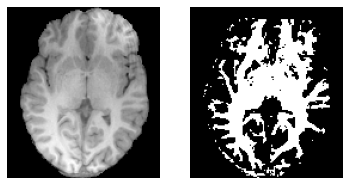

In [206]:
plt.figure()
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(case1Data[:, :, sli].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((dti_peaks.gfa[:, :, sli] > 0.12).T, cmap='gray', origin='lower')

In [33]:
case1Data.shape

(128, 144, 128)

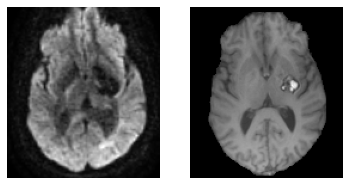

In [227]:
plt.figure()
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(diffussionData[:, :, sli,4].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(case1Data[:, :, sli].T, cmap='gray', origin='lower')
plt.savefig('diff_t1.png')

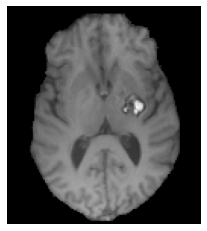

In [232]:
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(case1Data[:, :, sli].T, cmap='gray', origin='lower')
plt.savefig('t1_1.png')

## Tractography mapping (white matter streamlines)

In [31]:
from dipy.tracking import utils

In [130]:
# defining the seeds where tracking will start
seed_mask = white_matter
seeds = utils.seeds_from_mask(seed_mask,affine,density=[1,1,1])

In [97]:
# defining the tracking stopping criteria
dti_fit = dti_model.fit(maskData)
fa = dti_fit.fa

In [34]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
stopping_criterion = ThresholdStoppingCriterion(fa,0.2)

In [35]:
# propagating the streamlines
from dipy.tracking.local_tracking import LocalTracking

In [131]:
# generate streamlines / round affine elements to integers
streamline_generator = LocalTracking(dti_peaks,stopping_criterion,seeds,affine,step_size=0.5)

In [80]:
from dipy.tracking.streamline import Streamlines

In [132]:
streamlines = Streamlines(streamline_generator)

In [133]:
# save the streamlines
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk

In [136]:
sft = StatefulTractogram(streamlines,img,Space.RASMM)
sft.remove_invalid_streamlines()

([41782,
  41845,
  47790,
  47941,
  47941,
  53961,
  53964,
  53964,
  53965,
  53966,
  53966,
  58983,
  58983,
  58983,
  58984,
  59243,
  59438,
  59505,
  59573,
  59573,
  59573,
  59573,
  60592,
  65781,
  65781,
  65976,
  66168,
  66168,
  66304,
  66445,
  66514,
  66514,
  66514,
  66514,
  66648,
  66648,
  67329,
  72731,
  72731,
  72928,
  73336,
  73336,
  73545,
  73545,
  73545,
  73545,
  73615,
  73615,
  73685,
  73685,
  73685,
  73685,
  73756,
  73818,
  74213,
  74213,
  74213,
  79372,
  80298,
  80652,
  80936,
  81475,
  86438,
  86540,
  86638,
  86739,
  86837,
  86936,
  87815,
  87815,
  88388,
  88452,
  88534,
  93864,
  93865,
  94445,
  94445,
  95514,
  95514,
  96163,
  101424,
  101425,
  101425,
  101519,
  101787,
  101787,
  101792,
  101792,
  102277,
  102564,
  102564,
  103286,
  103858,
  109346,
  109346,
  109914,
  110011,
  110011,
  110011,
  111085,
  111085,
  112081,
  112081,
  112387,
  117289,
  117289,
  117289,
  117576,


In [137]:
save_trk(sft,'dti_deterministic_tractography.trk',streamlines)

In [142]:
from dipy.viz import window, actor, colormap

In [140]:
# set color map
linesColor = colormap.line_colors(streamlines)

In [143]:
stramlines_actor = actor.line(streamlines,linesColor)
scene = window.Scene()
showm = window.ShowManager(scene, size=(1024,720), reset_camera=False)
showm.initialize()

NameError: name 'streamlines_actor' is not defined

In [144]:
scene.add(stramlines_actor)
showm.start()

## Orientation Distribution Function (ODF)

In [2]:
from dipy.viz import window, actor, has_fury
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

In [102]:
response, ratio = auto_response_ssst(gtab, diffussionData, roi_radii=10, fa_thr=0.7)

In [103]:
csa_model = CsaOdfModel(gtab, sh_order=6)

In [104]:
csa_peaks = peaks_from_model(csa_model, diffussionData, default_sphere,
                             relative_peak_threshold=.1,
                             min_separation_angle=25,
                             mask=white_matter)

In [16]:
# show direction field slice
if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
                                csa_peaks.peak_values,
                                colors=None))
    window.record(scene, out_path='csa_direction_field.png', size=(500, 500))
    if interactive:
        window.show(scene, size=(400, 400))

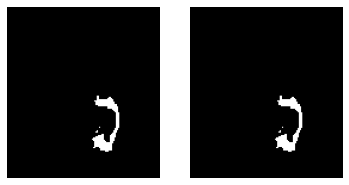

In [105]:
sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

In [37]:
csa_peaks.gfa.shape

(128, 144, 128)

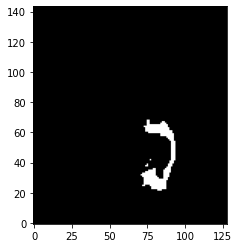

In [78]:
plt.imshow(white_matter[:, :, sli].T, cmap='gray', origin='lower')

In [60]:
white_matter.shape

(81, 106, 76)

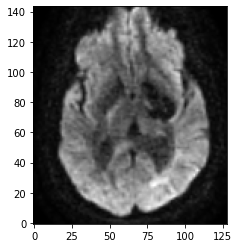

In [110]:
plt.imshow(diffussionData[:, :, sli,4].T, cmap='gray', origin='lower')

array([[   2.,    0.,    0.,  -80.],
       [   0.,    2.,    0., -120.],
       [   0.,    0.,    2.,  -60.],
       [   0.,    0.,    0.,    1.]])

In [99]:
from dipy.data import get_fnames
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
#labels = load_nifti_data(label_fname)
#bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
#gtab = gradient_table(bvals, bvecs)

In [49]:
white_matter = (labels == 1) | (labels == 2)

In [6]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=20, fa_thr=0.5)
csa_model = CsaOdfModel(gtab, sh_order=6)

In [7]:
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

In [ ]:
if has_fury:
    scene = window.Scene()
    scene.add(actor.peak_slicer(csa_peaks.peak_dirs,csa_peaks.peak_values,colors=None))
    window.record(scene, out_path='csa_direction_field.png', size=(900, 900))
    #window.show(scene, size=(800, 800))
    #window.ShowManager(scene).exit()

In [ ]:
window.ShowManager(scene).exit()

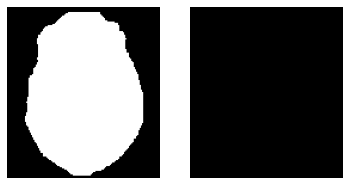

In [51]:
sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

plt.savefig('gfa_tracking_mask.png')

In [11]:
csa_peaks.gfa.shape

(81, 106, 76)

In [12]:
data.shape

(81, 106, 76, 160)

In [7]:
import numpy as np
from fury import window, actor, ui, io, utils

In [8]:
suzanne = io.load_polydata('suzanne.obj')
suzanne = utils.get_polymapper_from_polydata(suzanne)
suzanne = utils.get_actor_from_polymapper(suzanne)

In [9]:
suzanne.GetProperty().SetOpacity(0.5)

In [10]:
centers = np.random.rand(2, 3)
directions = np.random.rand(2, 3)
heights = np.random.rand(2)
colors = np.random.rand(2, 3)

In [11]:
cylinders = actor.cylinder(centers, directions, colors, heights=heights)

In [12]:
scene = window.Scene()

In [28]:
scene = window.Scene()
showm = window.ShowManager(scene, size=(1024,720), reset_camera=False)
showm.initialize()
scene.add(suzanne)
showm.start()

In [29]:
tb = ui.TextBlock2D()
tb.message = "Hello Fury"

In [30]:
scene.add(suzanne)
scene.add(cylinders)
scene.add(tb)

In [31]:
showm.start()

In [34]:
showm.exit()

AttributeError: 'ShowManager' object has no attribute 'iren'

In [35]:
showm.destroy_timer()

TypeError: destroy_timer() missing 1 required positional argument: 'timer_id'